In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk import unit

# Harmonic Well Potential

The harmonic well potential is described by the following expression:

\begin{equation}
f(x)=\frac{1}{2} k \left(x^2 + y^2 + z^2 \right)
\end{equation}

Where $k$ is the only parameter and represents the stiffness of the harmonic potential -or the stiffness of the harmonic spring described by the hookes' law-. Notice that the potential for potential dimensions $Y$ and $Z$, has the same shape. In this way we have a three dimensional harmonic well. But let's see here only the proyection over a single dimension $X$ since $Y$ and $Z$ are decorrelated, and there by will behave as $X$.

In [2]:
def harmonic_well(x,k):
    return 0.5*k*x**2

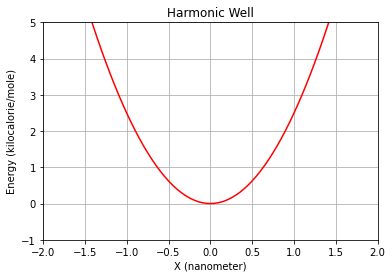

In [3]:
k=5.0 * unit.kilocalories_per_mole/ unit.nanometers**2 # stiffness of the harmonic potential

x_serie = np.arange(-5., 5., 0.05) * unit.nanometers

plt.plot(x_serie, harmonic_well(x_serie, k), 'r-')
plt.ylim(-1,5)
plt.xlim(-2,2)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Harmonic Well")
plt.show()

Different values of $k$ can be tested to graphically see how this parameter accounts for the openness of the well's arms. Or, as it is described below, the period of oscillations of a particle of mass $m$ in a newtonian dynamics.

The hooks' law describes the force suffered by a mass attached to an ideal spring as:

\begin{equation}
F(x) = -k(x-x_{0})
\end{equation}

Where $k$ is the stiffness of the spring and $x_{0}$ is the equilibrium position. Now, since the force is minus the gradient of the potential energy $V(x)$,

\begin{equation}
F(x) = -\frac{d V(x)}{dx},
\end{equation}

we can proof that the spring force is the result of the first harmonic potential derivative:

\begin{equation}
V(x) = \frac{1}{2} k (x-x_{0})^{2}
\end{equation}

And the angular frequency of oscillations of a spring, or a particle goberned by the former potential, is:

\begin{equation}
\omega = \sqrt{\frac{k}{m}}
\end{equation}

Where $m$ is the mass of the particle. This way the potential can also be written as:

\begin{equation}
V(x) = \frac{1}{2} k (x-x_{0})^{2} = \frac{1}{2} m \omega^{2} (x-x_{0})^{2}
\end{equation}

Finnally, the time period of these oscillations are immediately computed from the mass of the particle, $m$, and the stiffness parameter $k$. Given that by definition:

\begin{equation}
T = 2\pi / \omega
\end{equation}

Then:

\begin{equation}
T = 2\pi \sqrt{\frac{m}{k}}
\end{equation}

In [18]:
mass = 32 * unit.amu
k=5.0 * unit.kilocalories_per_mole/unit.nanometers**2
system = mm.System()
system.addParticle(mass)

force = mm.CustomExternalForce('k*(z^2)')
force.addGlobalParameter('k', 0.5*k)
force.addParticle(0, [])
_ = system.addForce(force)

In [19]:
initial_positions = np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
initial_positions[0,:] = 1.0 * unit.nanometers

integration_timestep = 0.02 * unit.picoseconds
saving_timestep = 0.5 * unit.picoseconds
total_time = 50 * unit.picoseconds

steps_per_cicle = round(saving_timestep/integration_timestep)
n_steps = round(total_time/integration_timestep)
n_cicles = round(n_steps/steps_per_cicle)

# Integrator

temperature = 0.0*unit.kelvin
friction = 0.0/unit.picoseconds
integrator = mm.LangevinIntegrator(temperature, friction, integration_timestep)

# Platform

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

# Context.

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

# Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

time = np.zeros([n_cicles], np.float32) * unit.picoseconds
position = np.zeros([n_cicles, 1, 3], np.float32) * unit.nanometers
velocity = np.zeros([n_cicles, 1, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole

# Initial context in reporters

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
time[0] = state.getTime()
position[0] = state.getPositions()
velocity[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Integration loop saving every cicle steps

for ii in range(1, n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    position[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

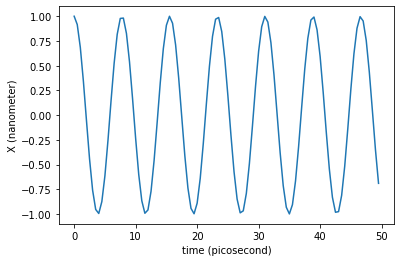

In [22]:
plt.plot(time, position[:,0,2])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

## Working with this test system

This test system is fully documented in [HarmonicWell class API](../api/_autosummary/uibcdf_test_systems.HarmonicWell.html). Let's see an example of how to interact with it:

In [ ]:
from openmolecularsystems import HarmonicWell

harmonic_well = HarmonicWell(n_particles = 1, mass = 32 * unit.amu,
                             k=5.0 * unit.kilocalories_per_mole/unit.nanometers**2)

The potential expression and the value of the parameters are stored in `potential`:

In [ ]:
harmonic_well.potential_expression

In [ ]:
harmonic_well.parameters

And there is a method to evaluate the potential at a given positions:

In [ ]:
harmonic_well.evaluate_potential([-1.5, 0.0, 0.0] * unit.nanometers)

In [ ]:
position = np.zeros((200,3), dtype=float) * unit.nanometers
position[:,0] = np.linspace(-5., 5., 200) * unit.nanometers

plt.plot(position[:,0], harmonic_well.evaluate_potential(position) , 'r-')
plt.ylim(-1,5)
plt.xlim(-2,2)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Harmonic Well")
plt.show()

### Newtonian dynamics

In [ ]:
system = harmonic_well.system
n_particles = system.getNumParticles()
initial_positions = np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
initial_positions[0,0] = 1.0 * unit.nanometers

integration_timestep = 0.02 * unit.picoseconds
saving_timestep = 0.5 * unit.picoseconds
total_time = 50 * unit.picoseconds

steps_per_cicle = round(saving_timestep/integration_timestep)
n_steps = round(total_time/integration_timestep)
n_cicles = round(n_steps/steps_per_cicle)

# Integrator

temperature = 0.0*unit.kelvin
friction = 0.0/unit.picoseconds
integrator = mm.LangevinIntegrator(temperature, friction, integration_timestep)

# Platform

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

# Context.

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

# Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

time = np.zeros([n_cicles], np.float32) * unit.picoseconds
position = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocity = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole

# Initial context in reporters

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
time[0] = state.getTime()
position[0] = state.getPositions()
velocity[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Integration loop saving every cicle steps

for ii in range(1, n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    position[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

We can now plot the trajectory of the x coordinate:

In [ ]:
plt.plot(time, position[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

We can wonder now if the period of these oscillations is in agreement with the value calculated above.

In [ ]:
mass = 32 * unit.amu
T = 2*np.pi*np.sqrt(mass/k)

print('The period of the small oscillations around the minimum is',T)

In [ ]:
harmonic_well.get_oscillations_time_period()

In [ ]:
plt.plot(time, position[:,0,0])
plt.axvline(T._value, color='gray', linestyle='--') # Period of the harmonic oscillations
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

Remember that the integration timestep must be smaller than $\sim T/10.0$ to guarantee that no artifacts are introduced by the timestep size.

The newtonian dynamics can also include damping. This way we can simulate damped oscillations around the minimum.

In [ ]:
friction = 0.25 / unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)
context.setTime(0.0*unit.picoseconds)

integrator.setFriction(friction)

# Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

time = np.zeros([n_cicles], np.float32) * unit.picoseconds
position = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocity = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole

# Initial context in reporters

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
time[0] = state.getTime()
position[0] = state.getPositions()
velocity[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Integration loop saving every cicle steps

for ii in range(1, n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    position[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

In [ ]:
plt.plot(time, position[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

What would be the friction value needed to enter in the overdamped regime?

In [ ]:
friction = 5.0 / unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)
context.setTime(0.0*unit.picoseconds)

integrator.setFriction(friction)

# Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

time = np.zeros([n_cicles], np.float32) * unit.picoseconds
position = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocity = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole

# Initial context in reporters

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
time[0] = state.getTime()
position[0] = state.getPositions()
velocity[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Integration loop saving every cicle steps

for ii in range(1, n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    position[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

In [ ]:
plt.plot(time, position[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

### Stochastic Dynamics

In [ ]:
temperature = 300 * unit.kelvin
friction = 1.0 / unit.picoseconds

integration_timestep = 0.02 * unit.picoseconds
saving_timestep = 0.5 * unit.picoseconds
total_time = 0.5 * unit.nanoseconds

steps_per_cicle = round(saving_timestep/integration_timestep)
n_steps = round(total_time/integration_timestep)
n_cicles = round(n_steps/steps_per_cicle)

initial_positions = np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
initial_positions[0,0] = 1.0 * unit.nanometers
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)
context.setTime(0.0*unit.picoseconds)

integrator.setFriction(friction)
integrator.setTemperature(temperature)

# Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

time = np.zeros([n_cicles], np.float32) * unit.picoseconds
position = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocity = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles], np.float32) * unit.kilocalories_per_mole

# Initial context in reporters

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
time[0] = state.getTime()
position[0] = state.getPositions()
velocity[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Integration loop saving every cicle steps

for ii in range(1, n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[ii] = state.getTime()
    position[ii] = state.getPositions()
    velocity[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

Let us see the time evolution of the coordinate $x$ of our single particle:

In [ ]:
plt.plot(time, position[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

In [ ]:
harmonic_well.get_standard_deviation(temperature)